In [4]:
# The workflow of this code consists of three parts:
# 1. Data Cleaning (the code was written in Jupiter notebooks and then incorporated into Google Colab)
# 2. Calculating Medians (more robust against outliers) and Distributions
# 3. Machine Learning Models (Multiple Linear Regression, basic Random Forest and Random Forest with advanced fatures)
# Each step includes code for visualization.

In [83]:
# PART I: DATA CLEANING (converting data types, removing nulls & duplicates, create agg. values like profit, etc)
# Import Python Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy import stats

#Import dependencies for Machine Models
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer

# Ignore all warning messages
warnings.filterwarnings('ignore')



In [6]:
# Uploading 'movie_metadata.csv' from Resources folder from our Git Hub repo
!wget https://github.com/LegallyNotBlonde/Movie_Analysis/raw/refs/heads/main/Resources/movie_metadata.csv

--2024-10-15 03:15:22--  https://github.com/LegallyNotBlonde/Movie_Analysis/raw/refs/heads/main/Resources/movie_metadata.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LegallyNotBlonde/Movie_Analysis/refs/heads/main/Resources/movie_metadata.csv [following]
--2024-10-15 03:15:22--  https://raw.githubusercontent.com/LegallyNotBlonde/Movie_Analysis/refs/heads/main/Resources/movie_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489644 (1.4M) [text/plain]
Saving to: ‘movie_metadata.csv.1’

movie_metadata.csv. 100%[===================>]   1.42M  --.-KB/s    in 0.04s   

2024-10-15 0

In [47]:

# Load the uploaded Excel file.
file_path = 'movie_metadata.csv'
# Set variable as the origibnal data
data_origin = pd.read_csv(file_path)
# Create a copy of the original data to keep it intactin case of any bugs
data = data_origin.copy()
# Display the first few rows of the dataset to understand its structure
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [48]:
# Clean the 'movie_title' column by removing 'Â' and any additional whitespace at the end
data['movie_title'] = data['movie_title'].str.replace('Â', '', regex=True).str.strip()
# Change the order of the columns and drop

In [49]:
# Change column order starting with defining the new column order
# Drop columns 'movie_imdb_link' and 'aspect_ratio'.
new_column_order = [
    'movie_title', 'gross', 'budget',  # Main movie details
    'actor_1_name', 'actor_1_facebook_likes',  # Actor 1 details
    'actor_2_name', 'actor_2_facebook_likes',  # Actor 2 details
    'actor_3_name', 'actor_3_facebook_likes',  # Actor 3 details
    'director_name', 'director_facebook_likes',  # Director details
    'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews',  # Movie-specific details
    'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',  # User and cast data
    'movie_facebook_likes',  # Add this column here
    'plot_keywords', 'genres', 'language', 'country', 'content_rating', 'imdb_score', 'color',  # Other features
]

# Reorder the DataFrame based on the new column order
data = data[new_column_order]

# Check the first three of our restructured data
print(data.head(3))

                                movie_title        gross       budget  \
0                                    Avatar  760505847.0  237000000.0   
1  Pirates of the Caribbean: At World's End  309404152.0  300000000.0   
2                                   Spectre  200074175.0  245000000.0   

      actor_1_name  actor_1_facebook_likes      actor_2_name  \
0      CCH Pounder                  1000.0  Joel David Moore   
1      Johnny Depp                 40000.0     Orlando Bloom   
2  Christoph Waltz                 11000.0      Rory Kinnear   

   actor_2_facebook_likes      actor_3_name  actor_3_facebook_likes  \
0                   936.0         Wes Studi                   855.0   
1                  5000.0    Jack Davenport                  1000.0   
2                   393.0  Stephanie Sigman                   161.0   

    director_name  ...  cast_total_facebook_likes  facenumber_in_poster  \
0   James Cameron  ...                       4834                   0.0   
1  Gore Verbins

In [50]:
# Make a copy of the data for debugging purposes
m_data = data.copy()
# Filter the data to include only rows where the 'country' column is equal to 'USA'
filtered_data = m_data[data['country'] == 'USA']
# We would like to limit the scope for the US only to remove biasis as we want to focus on movies produced in USA
# and remove potential biases for other movies that may not consider USA as a primary target market

In [51]:
# Fill missing values for string columns like 'director_name' with 'Unknown'
filtered_data.loc[:, ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']] = filtered_data.loc[:, ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']].fillna('Unknown')

# Replace 'Unrated' with 'Not rated' in the 'content_rating' column
filtered_data.loc[:, 'content_rating'] = filtered_data['content_rating'].replace('Unrated', 'Not rated')

# Drop rows with any other missing values to create a more accurate machine learning model
transformed_data = filtered_data.dropna()

In [52]:
# Get the number of rows in the DataFrame to verify data size and successful data type conversion for 'gross' and 'budget' columns
# Check if any other values need conversion
num_rows = transformed_data.shape[0]

# Get the data types of each column
data_types = transformed_data.dtypes

# Display the results
print(f"Number of the remaining rows: {num_rows}")
print("\nData types of each column:")
print(data_types)

Number of the remaining rows: 3026

Data types of each column:
movie_title                   object
gross                        float64
budget                       float64
actor_1_name                  object
actor_1_facebook_likes       float64
actor_2_name                  object
actor_2_facebook_likes       float64
actor_3_name                  object
actor_3_facebook_likes       float64
director_name                 object
director_facebook_likes      float64
duration                     float64
title_year                   float64
num_critic_for_reviews       float64
num_user_for_reviews         float64
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
movie_facebook_likes           int64
plot_keywords                 object
genres                        object
language                      object
country                       object
content_rating                object
imdb_score                   float64
color       

In [53]:
# Convert 'budget' and 'gross' columns to integers. Rpounded to the whole numbers
data['budget'] = pd.to_numeric(data['budget'], errors='coerce').fillna(0).round(0).astype(int)
data['gross'] = pd.to_numeric(data['gross'], errors='coerce').fillna(0).round(0).astype(int)

# Use .loc to modify the data types in other columns without triggering Warning messages
transformed_data.loc[:, 'actor_1_facebook_likes'] = pd.to_numeric(transformed_data['actor_1_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'actor_2_facebook_likes'] = pd.to_numeric(transformed_data['actor_2_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'actor_3_facebook_likes'] = pd.to_numeric(transformed_data['actor_3_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'num_critic_for_reviews'] = pd.to_numeric(transformed_data['num_critic_for_reviews'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'num_user_for_reviews'] = pd.to_numeric(transformed_data['num_user_for_reviews'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'facenumber_in_poster'] = pd.to_numeric(transformed_data['facenumber_in_poster'], errors='coerce').fillna(0).round(0).astype(int)

# Convert the 'title_year' column to integer format, ensuring proper handling of missing values
transformed_data['title_year'] = pd.to_numeric(transformed_data['title_year'], errors='coerce').astype('Int64')

# Display the first 5 rows of the data
transformed_data.head()


,movie_title,gross,budget,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,director_name,...,cast_total_facebook_likes,facenumber_in_poster,movie_facebook_likes,plot_keywords,genres,language,country,content_rating,imdb_score,color
0,Avatar,760505847.0,237000000.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,James Cameron,...,4834,0.0,33000,avatar|future|marine|native|paraplegic,Action|Adventure|Fantasy|Sci-Fi,English,USA,PG-13,7.9,Color
1,Pirates of the Caribbean: At World's End,309404152.0,300000000.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,Gore Verbinski,...,48350,0.0,0,goddess|marriage ceremony|marriage proposal|pi...,Action|Adventure|Fantasy,English,USA,PG-13,7.1,Color
3,The Dark Knight Rises,448130642.0,250000000.0,Tom Hardy,27000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,23000.0,Christopher Nolan,...,106759,0.0,164000,deception|imprisonment|lawlessness|police offi...,Action|Thriller,English,USA,PG-13,8.5,Color
5,John Carter,73058679.0,263700000.0,Daryl Sabara,640.0,Samantha Morton,632.0,Polly Walker,530.0,Andrew Stanton,...,1873,1.0,24000,alien|american civil war|male nipple|mars|prin...,Action|Adventure|Sci-Fi,English,USA,PG-13,6.6,Color
6,Spider-Man 3,336530303.0,258000000.0,J.K. Simmons,24000.0,James Franco,11000.0,Kirsten Dunst,4000.0,Sam Raimi,...,46055,0.0,0,sandman|spider man|symbiote|venom|villain,Action|Adventure|Romance,English,USA,PG-13,6.2,Color


In [54]:
# Remove rows where 'movie_title' has duplicates (keep the first occurrence and drop others)
cleaned_data = transformed_data.drop_duplicates(subset=['movie_title'], keep='first')
# That removes movies wiht identical titles and avoid potential confusion

In [67]:
# Make a copy of 'cleaned_data' for debugging purposes
# for debugging purposes
cleaned_data = cleaned_data.copy()

# Create a new column for profit using .loc
cleaned_data.loc[:, 'profit'] = cleaned_data['gross'] - cleaned_data['budget']


In [68]:
# Ensure that the 'profit' column is numeric, and convert if necessary to integers
cleaned_data['profit'] = pd.to_numeric(cleaned_data['profit'], errors='coerce').fillna(0).astype(int)
# Show cleaned data size
cleaned_data.shape

(2945, 27)

In [69]:
# Save files to the default Google Colab Directory
cleaned_data.to_csv('/content/cleaned_data.csv', index=False)

In [18]:
# PART II: DATA EXPLORATION NAD DISTRIBUTIONS

In [19]:
# PART III: MACHINE LEARNING MODELS USING CLEAN DATA and GOOGLE COLAB
# We used Multiple Linear Regression as a baseline metric and a Random Forest model based on the data type

In [70]:
# Read the 'cleaned_data.csv' file from the Colab default content directory
cleaned_data = pd.read_csv('/content/cleaned_data.csv')

# Create a copy of the data to keep the original data intact in case of any errors
movie_data = cleaned_data.copy()
# Display the first 5 rows of the loaded data
movie_data.head()


,movie_title,gross,budget,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,director_name,...,facenumber_in_poster,movie_facebook_likes,plot_keywords,genres,language,country,content_rating,imdb_score,color,profit
0,Avatar,760505847.0,237000000.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,James Cameron,...,0.0,33000,avatar|future|marine|native|paraplegic,Action|Adventure|Fantasy|Sci-Fi,English,USA,PG-13,7.9,Color,523505847
1,Pirates of the Caribbean: At World's End,309404152.0,300000000.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,Gore Verbinski,...,0.0,0,goddess|marriage ceremony|marriage proposal|pi...,Action|Adventure|Fantasy,English,USA,PG-13,7.1,Color,9404152
2,The Dark Knight Rises,448130642.0,250000000.0,Tom Hardy,27000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,23000.0,Christopher Nolan,...,0.0,164000,deception|imprisonment|lawlessness|police offi...,Action|Thriller,English,USA,PG-13,8.5,Color,198130642
3,John Carter,73058679.0,263700000.0,Daryl Sabara,640.0,Samantha Morton,632.0,Polly Walker,530.0,Andrew Stanton,...,1.0,24000,alien|american civil war|male nipple|mars|prin...,Action|Adventure|Sci-Fi,English,USA,PG-13,6.6,Color,-190641321
4,Spider-Man 3,336530303.0,258000000.0,J.K. Simmons,24000.0,James Franco,11000.0,Kirsten Dunst,4000.0,Sam Raimi,...,0.0,0,sandman|spider man|symbiote|venom|villain,Action|Adventure|Romance,English,USA,PG-13,6.2,Color,78530303


In [71]:
# Get the number of rows in the date (to verify the data size)
num_rows = movie_data.shape[0]
# Print the result
print(f"Number of rows in the dataset: {num_rows}")

Number of rows in the dataset: 2945


In [72]:
# Verify success of data clean up: Check for missing values in the 'updated_data' DataFrame
missing_values = movie_data.isnull().sum()

# Display the result
print(missing_values)

movie_title                  0
gross                        0
budget                       0
actor_1_name                 0
actor_1_facebook_likes       0
actor_2_name                 0
actor_2_facebook_likes       0
actor_3_name                 0
actor_3_facebook_likes       0
director_name                0
director_facebook_likes      0
duration                     0
title_year                   0
num_critic_for_reviews       0
num_user_for_reviews         0
num_voted_users              0
cast_total_facebook_likes    0
facenumber_in_poster         0
movie_facebook_likes         0
plot_keywords                0
genres                       0
language                     0
country                      0
content_rating               0
imdb_score                   0
color                        0
profit                       0
dtype: int64


In [61]:
# The outlook above shows that the data no longer has any missing values.

In [73]:
# Convert the 'duration', 'gross', 'budget', and 'title_year' columns from float to integer
movie_data['duration'] = pd.to_numeric(movie_data['duration'], errors='coerce').fillna(0).astype(int)
movie_data['gross'] = pd.to_numeric(movie_data['gross'], errors='coerce').fillna(0).astype(int)
movie_data['budget'] = pd.to_numeric(movie_data['budget'], errors='coerce').fillna(0).astype(int)
movie_data['title_year'] = pd.to_numeric(movie_data['title_year'], errors='coerce').fillna(0).astype(int)

# Verify the data types after conversion
print(movie_data.dtypes)

movie_title                   object
gross                          int64
budget                         int64
actor_1_name                  object
actor_1_facebook_likes       float64
actor_2_name                  object
actor_2_facebook_likes       float64
actor_3_name                  object
actor_3_facebook_likes       float64
director_name                 object
director_facebook_likes      float64
duration                       int64
title_year                     int64
num_critic_for_reviews       float64
num_user_for_reviews         float64
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
movie_facebook_likes           int64
plot_keywords                 object
genres                        object
language                      object
country                       object
content_rating                object
imdb_score                   float64
color                         object
profit                         int64
d

In [74]:
# STEP 3.1: MULTIPLE LINEAR REGRESSION MODEL
# For Linear Regression Models StandardScaler seems to be the better choice:
# It centers the data around zero and can handle varying scales more effectively.
# MinMaxScaler may compress the majority of the data into a small range, which can negatively impact the performance of linear regression

# To avoid biases and unnecessary information, we drop 'profit' and movie_title from our data before starting our model:
movie_data = movie_data.drop(['profit', 'movie_title'], axis=1)

In [75]:
# Create a copy of the data
movies_mlr = movie_data.copy()

In [76]:
# List of numerical features to be scaled
numerical_features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                      'actor_3_facebook_likes', 'director_facebook_likes', 'duration',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                      'cast_total_facebook_likes', 'movie_facebook_likes']

# Set StandardScaler as the best scaler option for Linear regression model
scaler = StandardScaler()
# Scale the numerical columns
movies_mlr[numerical_features] = scaler.fit_transform(movies_mlr[numerical_features])

In [77]:
# Encode categorical variables using one-hot encoding
categorical_features = ['genres', 'content_rating', 'language', 'actor_1_name',
                        'actor_2_name', 'actor_3_name', 'director_name',
                        'plot_keywords', 'country', 'color']

In [78]:
# Filter out the categorical features that exist in the movies_us DataFrame
categorical_features = [col for col in categorical_features if col in movies_mlr.columns]

In [79]:
# Apply one-hot encoding to the existing categorical features
movies_mlr = pd.get_dummies(movies_mlr, columns=categorical_features, drop_first=True)

# Set the features and target after encoding
X = movies_mlr.drop(columns=['gross'])  # Independent variables
y = movies_mlr['gross']  # Dependent variable

In [31]:
# Identify numerical columns only in X for imputation
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Apply the imputer only to the numerical columns
imputer = SimpleImputer(strategy='mean')
X[numerical_columns] = imputer.fit_transform(X[numerical_columns])

In [32]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

In [33]:
# Assess Multiple Linear Regression Model Accuracy
r2_mlr = r2_score(y_test, y_pred)
mse_mlr = mean_squared_error(y_test, y_pred)
mae_mlr = mean_absolute_error(y_test, y_pred)
rmse_mlr = np.sqrt(mse_mlr)

# Print all metrics for Multiple Linear Regression Model
print(f'R-squared, Multiple Linear Regression Model: {r2_mlr}')
print(f'Mean Squared Error, Multiple Linear Regression Model: {mse_mlr}')
print(f'Mean Absolute Error, Multiple Linear Regression Model: {mae_mlr}')
print(f'Root Mean Squared Error, Multiple Linear Regression Model: {rmse_mlr}')

R-squared, Multiple Linear Regression Model: 0.5811843526898337
Mean Squared Error, Multiple Linear Regression Model: 2146088079719227.5
Mean Absolute Error, Multiple Linear Regression Model: 31743534.21760497
Root Mean Squared Error, Multiple Linear Regression Model: 46325889.95064452


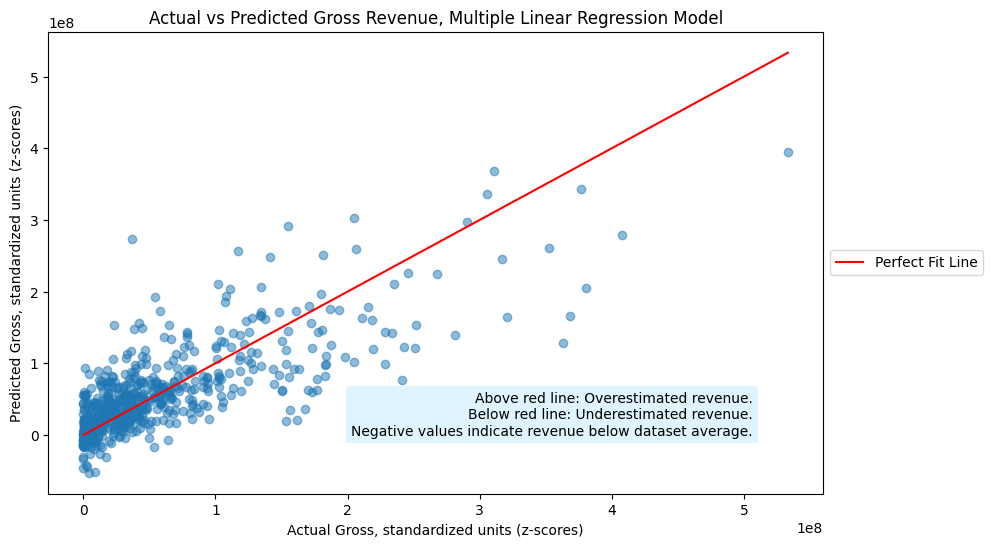

In [87]:
# Set plot details
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
# Set Perfect Fit Line in red color
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Fit Line')
plt.title('Actual vs Predicted Gross Revenue, Multiple Linear Regression Model')
plt.xlabel('Actual Gross, standardized units (z-scores)')
plt.ylabel('Predicted Gross, standardized units (z-scores)')

# Linking the legend to the plot elements and moving it to the center right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

# Adding the text box with additional information and placing it in the lower right
plt.text(max(y_test) * 0.95, min(y_test) * 1.05,
         "Above red line: Overestimated revenue.\n"
         "Below red line: Underestimated revenue.\n"
         "Negative values indicate revenue below dataset average.",
         ha='right', fontsize=10, bbox=dict(facecolor='#cceeff', edgecolor='none', alpha=0.6))

# Display the plot
plt.show()

In [81]:
# The model explains about 58% of the variation in movie revenue based on the factors included, indicating a decent fit.
# However, 43% of the variation remains unexplained, suggesting that other influences not captured by the model may be contributing.
# The error rate (0.4236) shows how close the predictions are to actual values, but we need to compare it with other models to see how reliable it really is

In [88]:
# STEP 3.2. RANDOM FOREST MODEL on raw data(wihtout optimozation)
# Using Standard Scaling for Numeric Features and get_dummies finction for categorical values

# Create a copy of the original cleaned data
movies_brf = movie_data.copy()


# Selecting independable features and target
features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
            'actor_3_facebook_likes', 'director_facebook_likes',
            'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
            'num_voted_users', 'cast_total_facebook_likes',
            'facenumber_in_poster', 'movie_facebook_likes',
            'imdb_score', 'genres', 'content_rating', 'language', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name', 'plot_keywords', 'country', 'color' ]

X = movies_brf[features]
y = movies_brf['gross']

# One-hot encoding categorical columns using pd.get_dummies()
X = pd.get_dummies(X, columns=['genres', 'content_rating', 'language','actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name', 'plot_keywords', 'country', 'color' ], drop_first=True)

# Standard Scaling for numerical columns
numerical_features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                      'actor_3_facebook_likes', 'director_facebook_likes', 'duration',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                      'cast_total_facebook_likes', 'facenumber_in_poster', 'movie_facebook_likes', 'imdb_score']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred_brf = model.predict(X_test)

# Model evaluation
r2_brf = r2_score(y_test, y_pred_brf)
mse_brf = mean_squared_error(y_test, y_pred_brf)
mae_brf = mean_absolute_error(y_test, y_pred_brf)
rmse_brf = np.sqrt(mse_brf)

# Print all metrics for basic Rando Forest Model
print(f'R^2 Score, basic Random Forest, all features: {r2_brf}')
print(f'Mean Squared Error, basic Random Forest, all features:  {mse_brf}')
print(f'Mean Absolute Error, basic Random Forest, all features: {mae_brf}')
print(f'Root Mean Squared Error, basic Random Forest, all features:  {rmse_brf}')



R^2 Score, basic Random Forest, all features: 0.6797875941774495
Mean Squared Error, basic Random Forest, all features:  1640827011902595.2
Mean Absolute Error, basic Random Forest, all features: 24852675.706146006
Root Mean Squared Error, basic Random Forest, all features:  40507122.97735542


In [37]:
# The Random Forest Model that accounts both categorical and scaled numeric features
# has the higher R² score of 0.68-0.69 depending on the run and MSE is lower.
# This is a 0.12 score improvement in R^2 score comparing to the initial Multiple Linear Regression model

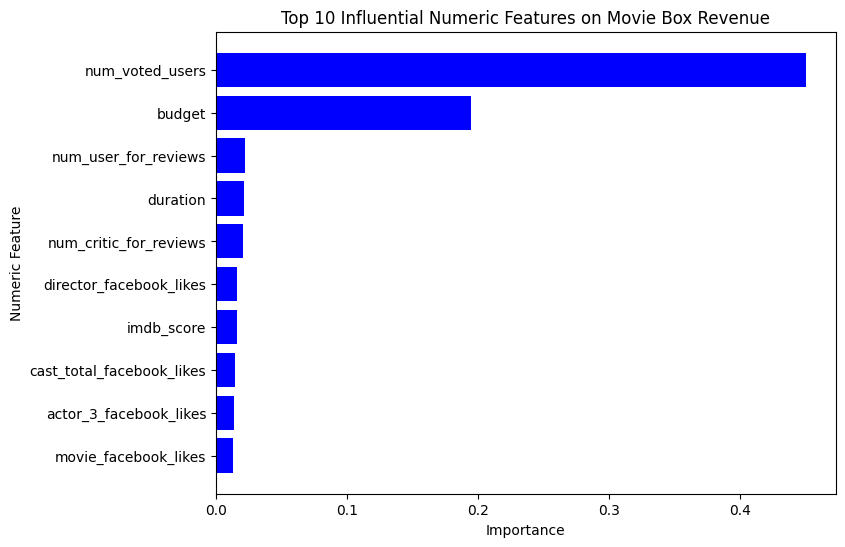

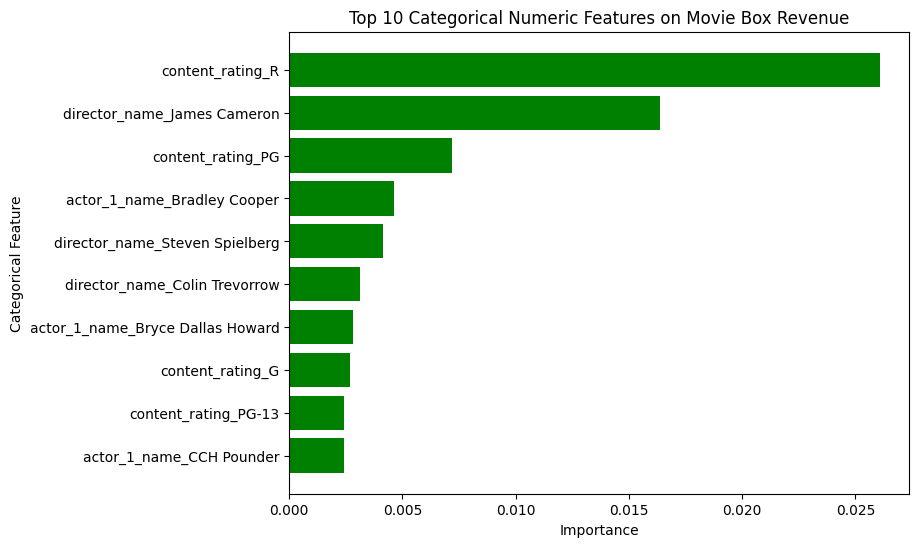

In [89]:
# This code evaluates FEATURE IMPORTANCE for both numerical and categorical features basic Random Forest on raw data
# Extracting feature importances from the model
importances = model.feature_importances_

# Get the correct feature names (if some features were dropped during preprocessing, align them)
if len(importances) == len(X.columns):
    all_feature_names = X.columns
else:
    all_feature_names = X.columns[:len(importances)]  # Adjust if necessary

# Creating a DataFrame for feature importances
features_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})

# Identifying one-hot encoded categorical features based on their prefixes
categorical_encoded_features = [col for col in all_feature_names if any(col.startswith(prefix) for prefix in categorical_features)]

# Identify numeric features (columns of type 'int64' or 'float64')
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Creating DataFrames for numeric and categorical features
numeric_importance_df = features_importance_df[features_importance_df['Feature'].isin(numeric_features)]
categorical_importance_df = features_importance_df[features_importance_df['Feature'].isin(categorical_encoded_features)]

# Sorting and selecting the top 10 most influential features for each type
top_numeric_features = numeric_importance_df.sort_values(by='Importance', ascending=False).head(10)
top_categorical_features = categorical_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the top 10 numeric features
plt.figure(figsize=(8, 6))
plt.barh(top_numeric_features['Feature'][::-1], top_numeric_features['Importance'][::-1], color='blue')
plt.xlabel('Importance')
plt.ylabel('Numeric Feature')
plt.title('Top 10 Influential Numeric Features on Movie Box Revenue')
plt.show()

# Plotting the top 10 categorical features
plt.figure(figsize=(8, 6))
plt.barh(top_categorical_features['Feature'][::-1], top_categorical_features['Importance'][::-1], color='green')
plt.xlabel('Importance')
plt.ylabel('Categorical Feature')
plt.title('Top 10 Categorical Numeric Features on Movie Box Revenue')
plt.show()

In [90]:
# Output the top 10 numeric and categorical features with their importance scores
print("Top 10 Numeric Features and Their Importance Scores:")
print(top_numeric_features)

print("\nTop 10 Categorical Features and Their Importance Scores:")
print(top_categorical_features)

Top 10 Numeric Features and Their Importance Scores:
                      Feature  Importance
8             num_voted_users    0.450920
0                      budget    0.194484
7        num_user_for_reviews    0.022214
5                    duration    0.021747
6      num_critic_for_reviews    0.020473
4     director_facebook_likes    0.016492
12                 imdb_score    0.016041
9   cast_total_facebook_likes    0.014630
3      actor_3_facebook_likes    0.013636
11       movie_facebook_likes    0.012812

Top 10 Categorical Features and Their Importance Scores:
                               Feature  Importance
667                   content_rating_R    0.026069
6252       director_name_James Cameron    0.016358
664                  content_rating_PG    0.007190
806        actor_1_name_Bradley Cooper    0.004632
6986    director_name_Steven Spielberg    0.004165
5953     director_name_Colin Trevorrow    0.003136
825   actor_1_name_Bryce Dallas Howard    0.002797
659                

In [40]:
# STEP 3.3. RANDOM FOREST MODEL with engineering features (JEAN)

In [91]:
# Make a copy of the original cleaned data
movie_data_opt = movie_data.copy()

In [41]:
# STEP 4: Combine model assessment metrics into a single DataFrame
# Display the metrics using graphs

In [98]:
# Combine R-Squared, MSE, MAE, and RMSE into a DataFrame
model_comparison = pd.DataFrame({
    'Model': ['Multiple Linear Regression', 'Basic Random Forest before optimization'],
    'R-Squared': [r2_mlr, r2_brf],
    'Mean Squared Error': [mse_mlr, mse_brf],
    'Mean Absolute Error': [mae_mlr, mae_brf],
    'Root Mean Squared Error': [rmse_mlr, rmse_brf]
})

# Show DataFrame
print(model_comparison)


                                     Model  R-Squared  Mean Squared Error  \
0               Multiple Linear Regression   0.581184        2.146088e+15   
1  Basic Random Forest before optimization   0.679788        1.640827e+15   

   Mean Absolute Error  Root Mean Squared Error  
0         3.174353e+07             4.632589e+07  
1         2.485268e+07             4.050712e+07  


In [99]:
# Save files to the default Google Colab Directory
model_comparison.to_csv('/content/model_comparison.csv', index=False)

In [93]:
# The Basic Random Forest is best suited than Multiple Linear Regression model:
# it has a higher R^2 and lower Mean Squared Error


Text(1.5, 0.5438300753419596, 'The closer R^2 to 1,\nthe higher the prediction accuracy.')

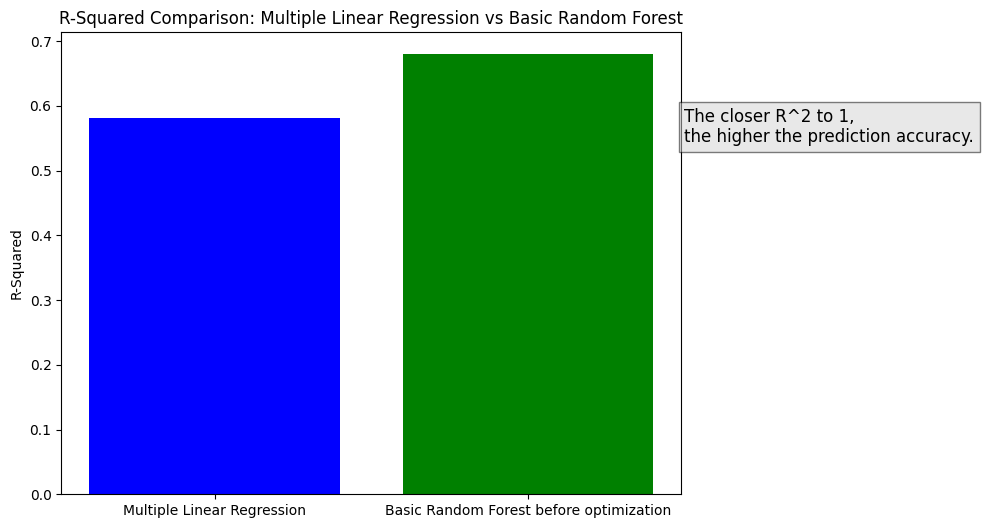

In [95]:
# Plotting R-Squared comparison
plt.figure(figsize=(8, 6))
plt.bar(model_comparison['Model'], model_comparison['R-Squared'], color=['blue', 'green'])
plt.title('R-Squared Comparison: Multiple Linear Regression vs Basic Random Forest')
plt.ylabel('R-Squared')

# Adding text box on the right center
plt.text(1.5, max(model_comparison['R-Squared']) * 0.8,
         'The closer R^2 to 1,\nthe higher the prediction accuracy.',
         fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

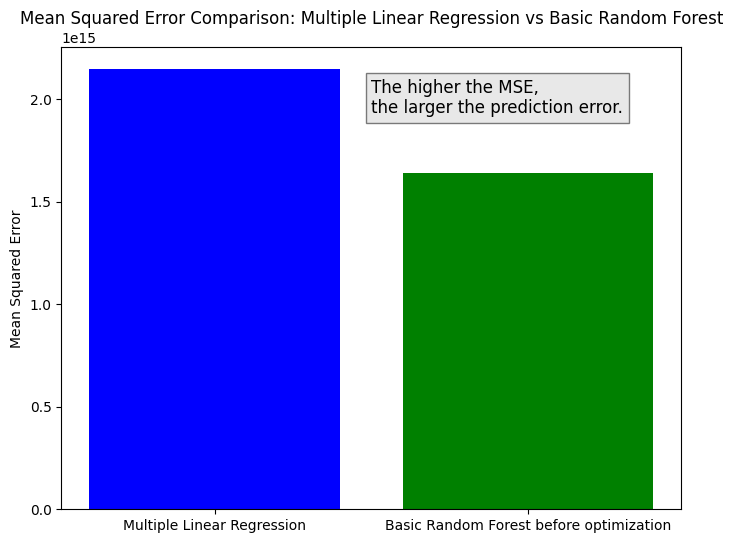

In [101]:
# Plotting Mean Squared Error comparison without a logarithmic scale
plt.figure(figsize=(8, 6))
plt.bar(model_comparison['Model'], model_comparison['Mean Squared Error'], color=['blue', 'green'])

# Set titles and labels
plt.title('Mean Squared Error Comparison: Multiple Linear Regression vs Basic Random Forest')
plt.ylabel('Mean Squared Error')

# Adjust the text box for normal scale
plt.text(0.5, max(model_comparison['Mean Squared Error']) * 0.9,  # Adjusted y-value for better placement on normal scale
         'The higher the MSE,\nthe larger the prediction error.',
         fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

# Display the plot
plt.show()

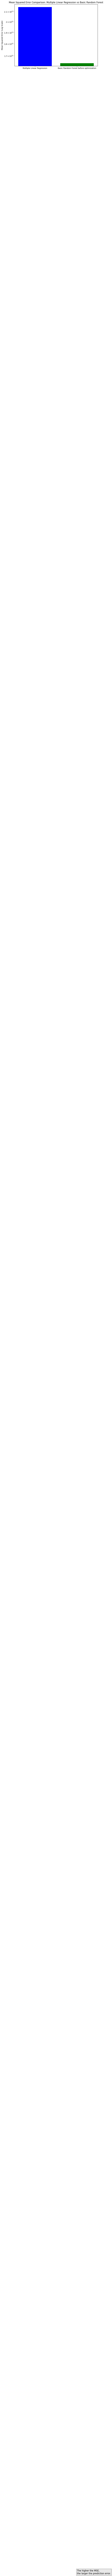

In [96]:
# Plotting Mean Squared Error comparison with a logarithmic scale
plt.figure(figsize=(8, 6))
plt.bar(model_comparison['Model'], model_comparison['Mean Squared Error'], color=['blue', 'green'])
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title('Mean Squared Error Comparison: Multiple Linear Regression vs Basic Random Forest')
plt.ylabel('Mean Squared Error (Log Scale)')

# Adding text box with adjusted placement for log scale
plt.text(1, 1e10,  # Adjusted y-value to fit better on the log scale
         'The higher the MSE,\nthe larger the prediction error.',
         fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

plt.show()

In [100]:
print(model_comparison['Mean Squared Error'])

0    2.146088e+15
1    1.640827e+15
Name: Mean Squared Error, dtype: float64


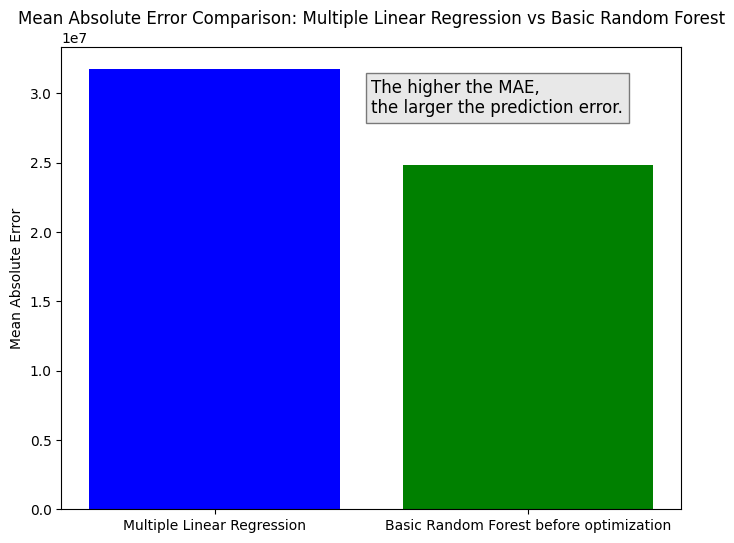

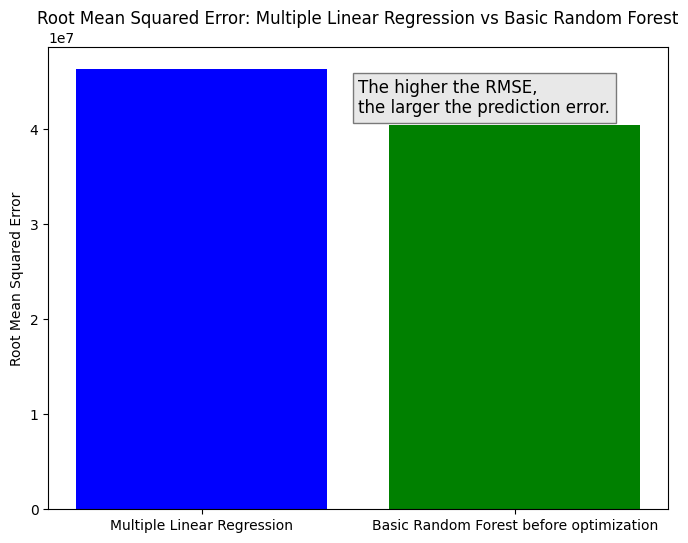

In [102]:
# Plotting Mean Absolute Error comparison without a logarithmic scale
plt.figure(figsize=(8, 6))
plt.bar(model_comparison['Model'], model_comparison['Mean Absolute Error'], color=['blue', 'green'])

# Set titles and labels for MAE plot
plt.title('Mean Absolute Error Comparison: Multiple Linear Regression vs Basic Random Forest')
plt.ylabel('Mean Absolute Error')

# Adjust the text box for normal scale in MAE plot
plt.text(0.5, max(model_comparison['Mean Absolute Error']) * 0.9,  # Adjusted y-value for better placement on normal scale
         'The higher the MAE,\nthe larger the prediction error.',
         fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

# Plotting Root Mean Squared Error comparison without a logarithmic scale
plt.figure(figsize=(8, 6))
plt.bar(model_comparison['Model'], model_comparison['Root Mean Squared Error'], color=['blue', 'green'])

# Set titles and labels for RMSE plot
plt.title('Root Mean Squared Error: Multiple Linear Regression vs Basic Random Forest')
plt.ylabel('Root Mean Squared Error')

# Adjust the text box for normal scale in RMSE plot
plt.text(0.5, max(model_comparison['Root Mean Squared Error']) * 0.9,  # Adjusted y-value for better placement on normal scale
         'The higher the RMSE,\nthe larger the prediction error.',
         fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

# Display both plots
plt.show()

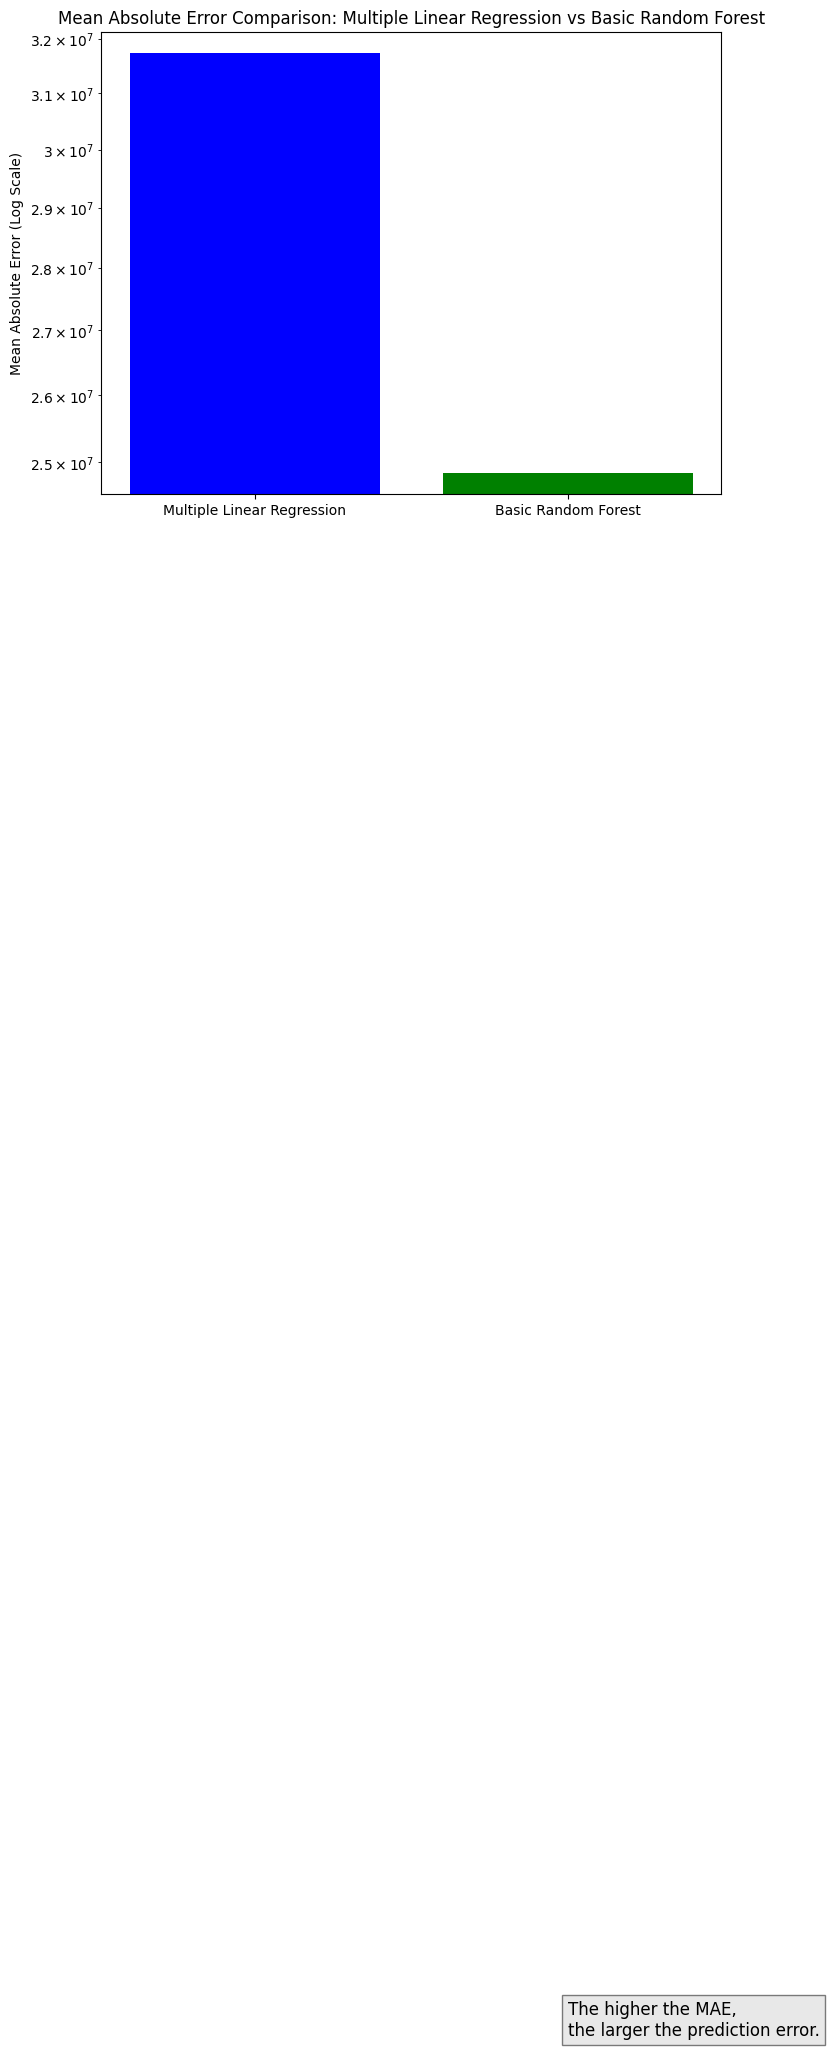

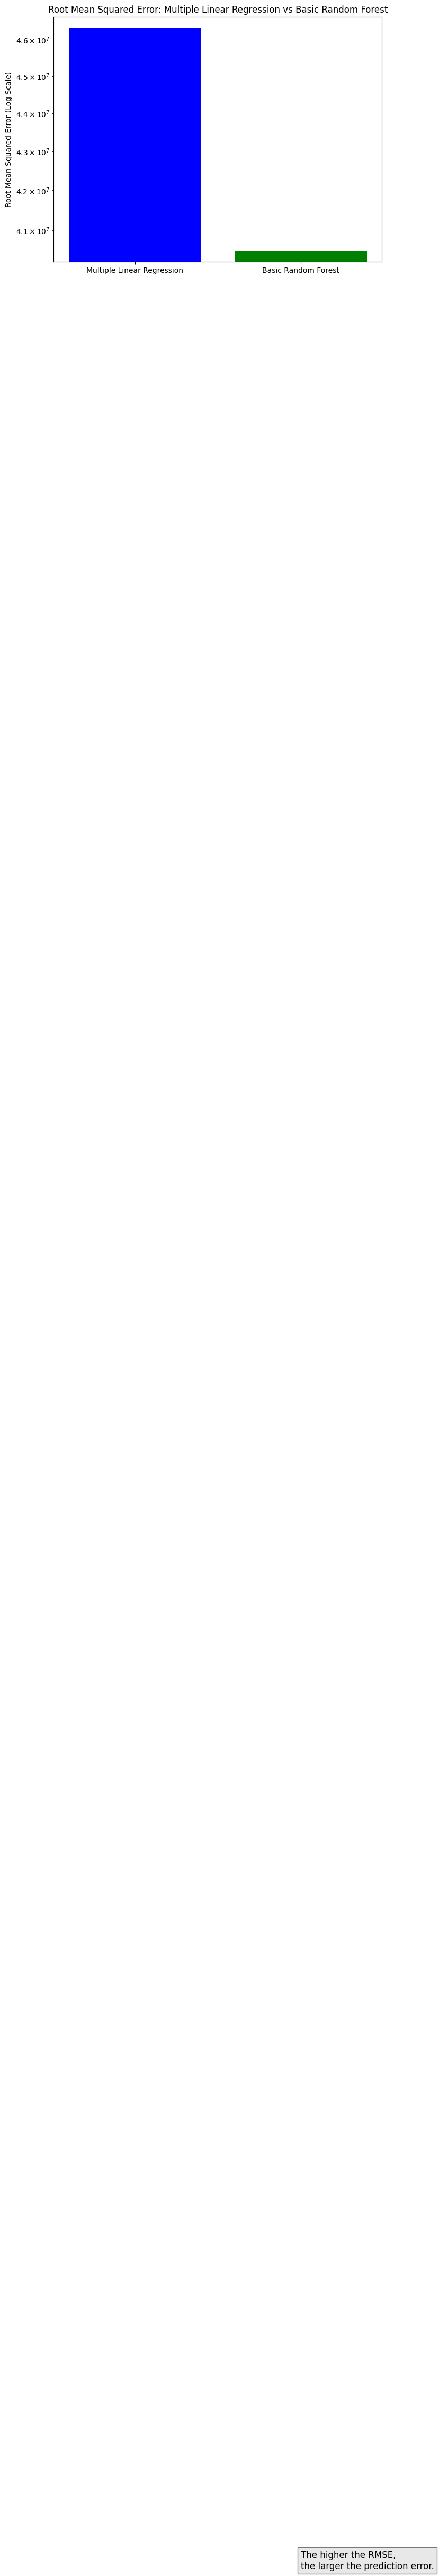

In [46]:
# Plotting Mean Absolute Error comparison with a logarithmic scale
plt.figure(figsize=(8, 6))
plt.bar(model_comparison['Model'], model_comparison['Mean Absolute Error'], color=['blue', 'green'])  # Removed space in 'Mean Absolute Error'
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title('Mean Absolute Error Comparison: Multiple Linear Regression vs Basic Random Forest')
plt.ylabel('Mean Absolute Error (Log Scale)')

# Adding text box with adjusted placement for log scale
plt.text(1, 1e7,  # Adjusted y-value for better placement
         'The higher the MAE,\nthe larger the prediction error.',
         fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

# Plotting Root Mean Squared Error comparison with a logarithmic scale
plt.figure(figsize=(8, 6))
plt.bar(model_comparison['Model'], model_comparison['Root Mean Squared Error'], color=['blue', 'green'])
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title('Root Mean Squared Error: Multiple Linear Regression vs Basic Random Forest')
plt.ylabel('Root Mean Squared Error (Log Scale)')

# Adding text box with adjusted placement for log scale
plt.text(1, 1e7,  # Adjusted y-value for better placement
         'The higher the RMSE,\nthe larger the prediction error.',
         fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

# Display both plots
plt.show()